<a href="https://colab.research.google.com/github/david-meltzer/quadratic_model/blob/main/catapult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#!pip install --upgrade torchvision>=11.7.0
!pip install functorch
!pip install num2words
!pip install requests-cache==0.6.0

%matplotlib inline
foldername = '/catapult_clean/'
%cd /content/drive/My\ Drive/$foldername

import sys
sys.path.append('/content/drive/My Drive/{}'.format(foldername))

import numpy as np
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_printoptions(precision=3)

%load_ext autoreload
%autoreload 2

In [ ]:
#import misc
#import models_V2
#import NTK_eigensystem
#import training
#import plots

from misc import CustomDataset
from models_V2 import Quadratic, quadratic_with_bias, MLPGeneral
from training import full_training_loop
from plots import collective_plots


In [ ]:
class toyDataset(Dataset):   
    def __len__(self):
        return 1
    def __getitem__(self,idx):
        x=torch.tensor([1]).float()
        y=0
        return x,y

In [ ]:

toy=CustomDataset(list(zip(torch.tensor([[1]]),torch.tensor([[0]]))))

In [ ]:
torch.set_printoptions(precision=3)

In [ ]:
model_dict={}

model_dict['input_dim']=1
model_dict['hidden_dim']=1000
model_dict['device']=device
train_batch_size=1

eval_dist={}
eval_dist['dist']='uniform'
eval_dist['params']=(1,1)
model_dict['eval_dist']=eval_dist

matrix_dist={}
matrix_dist['dist']='normal'
matrix_dist['params']=(0,1)
model_dict['matrix_dist']=matrix_dist

dataset={}
dataset['name']='toy_example'
dataset['train']=toy

lr_ratios=list(map(lambda x:round(x,2),np.arange(.5,4+.5,.5)))
max_epochs=1
stop_criterion=0
seed=123

arch=Quadratic

torch.set_printoptions(precision=2)


result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=10,
                    verbose=True,
                    write_file=False,
                    overwrite=False,
                    data_eigen=False)



computing averaged top eigenvalues and eigenvectors
[batch/total:  1/ 1]

Training at lr_ratio 0.5
epoch/total: 1/1, train loss: 0.0446698777377605, NTK: 0.4999603922197227
Total loss on training set: 0.0111679751425982

Training at lr_ratio 1.0
epoch/total: 1/1, train loss: 0.0446698777377605, NTK: 0.9998639702466594
Total loss on training set: 0.0000000000926962

Training at lr_ratio 1.5
epoch/total: 1/1, train loss: 0.0446698777377605, NTK: 1.4997450568198982
Total loss on training set: 0.0111629152670503

Training at lr_ratio 2.0
epoch/total: 1/1, train loss: 0.0446698777377605, NTK: 1.9996376143348094
Total loss on training set: 0.0446537546813488

Training at lr_ratio 2.5
epoch/total: 1/1, train loss: 0.0446698777377605, NTK: 2.4995753949862616
Total loss on training set: 0.1004693433642387

Training at lr_ratio 3.0
epoch/total: 1/1, train loss: 0.0446698777377605, NTK: 2.9995926314274133
Total loss on training set: 0.1786069273948669

Training at lr_ratio 3.5
epoch/total: 1/1, t

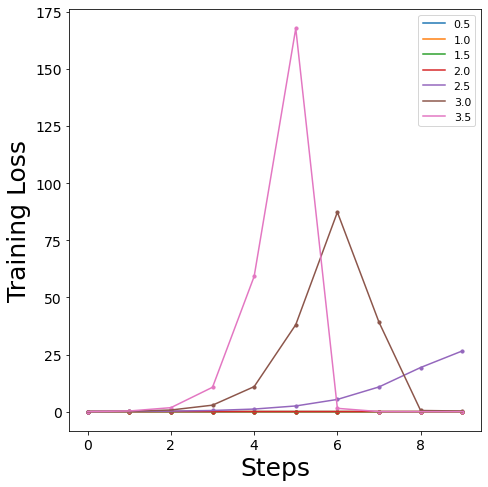

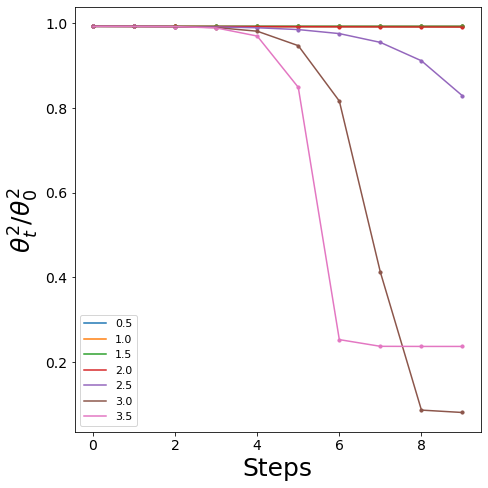

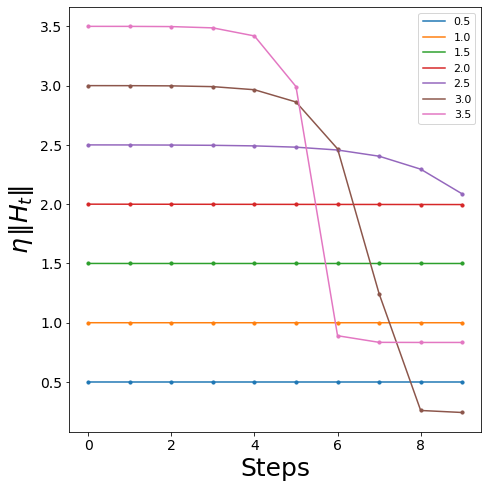

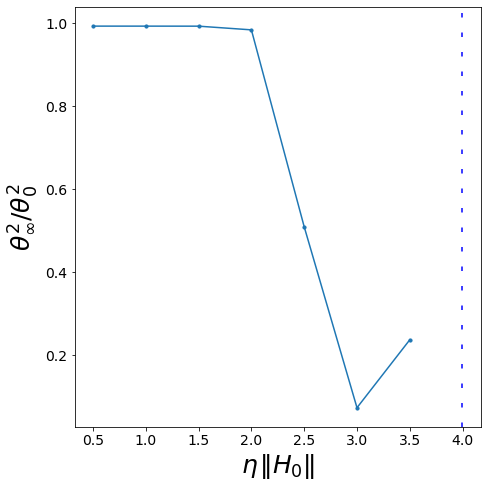

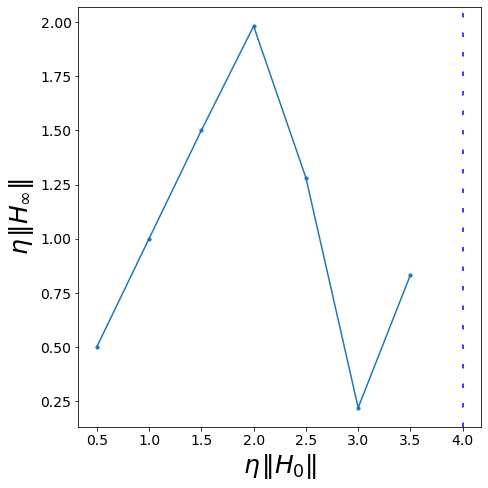

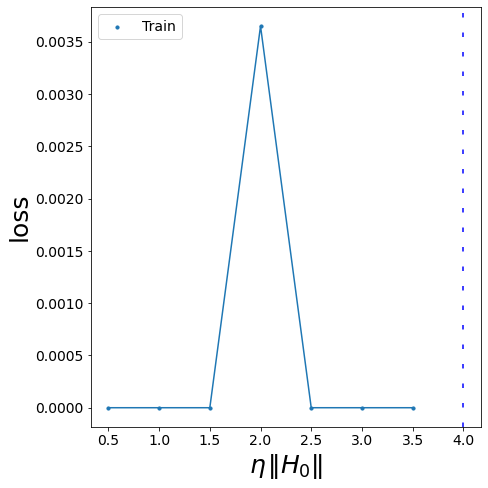

In [ ]:
collective_plots(result,0,10,False,True)

In [ ]:
result['lr_ratio',1.0]

{'loss': [0.044714659452438354],
 'weight_norm': [0.9929826049804688, 0.9928475341796875],
 'lrNTK': [1.0, 0.9998638782871337],
 'losses': {'train': 9.816430307507673e-11}}